### import Library and Data

In [2]:
import FinancialMachineLearning as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('./Data/IVE_tickbidask.parq')
#df = fml.getDataFrame(df)
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

86.96
[36.17 36.25 36.21 ... 29.26 29.26 29.26]
[1.41225268 1.41537627 1.41381447 ... 1.14245268 1.14245268 1.14245268]


,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2018-10-05 15:59:59,116.20,116.18,116.19,2000,2000,232400.00
2018-10-05 15:59:59,116.20,116.18,116.19,3900,3900,453180.00
2018-10-05 16:00:00,116.22,116.20,116.21,42884,42884,4983978.48


Dollar Bar Sampling

In [4]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.00
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.00
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.00
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.00
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.00
...,...,...,...,...,...,...
2018-10-05 15:58:23,116.19,116.19,116.20,1354,1354,157321.26
2018-10-05 15:59:20,116.18,116.17,116.19,300,300,34854.00
2018-10-05 15:59:55,116.19,116.18,116.20,800,800,92952.00


Fractionally Differencing

In [5]:
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(dollar_df).resample('1H').last().dropna() # daily return
        df2 = fml.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'price'], df2['price'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['price'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d.round(1)}, error: {e}')
        continue

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-1.092230,7.181607e-01,1.0,16056.0,-2.861720,1.000000
0.1,-0.765815,8.289581e-01,1.0,5.0,-3.929280,0.977330
0.2,-1.799711,3.806051e-01,1.0,10.0,-3.232950,0.968024
0.3,-2.461093,1.252301e-01,1.0,22.0,-3.005426,0.924809
0.4,-3.784537,3.069540e-03,1.0,54.0,-2.916770,0.834352
0.5,-3.798314,2.924611e-03,1.0,140.0,-2.882416,0.626855
0.6,-8.670902,4.549392e-14,1.0,386.0,-2.869057,0.216403
0.7,-17.046703,8.124175e-30,1.0,1131.0,-2.864099,0.234206
0.8,-32.011251,0.000000e+00,1.0,3435.0,-2.862382,0.056763
0.9,-60.484925,0.000000e+00,1.0,9231.0,-2.861853,0.015171


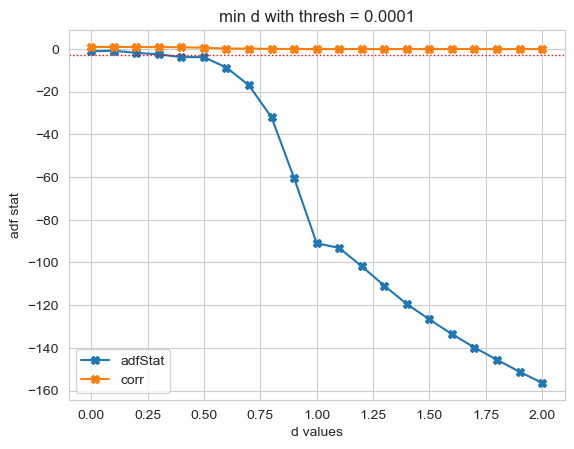

In [6]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat')
display(out)

In [7]:
min_ffd = out[out.pVal <= 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary", min_ffd.round(1))

The min. D that makes the fracdiff stationary 0.4


In [8]:
dfx2 = fml.fracDiff_FFD(dollar_df, min_ffd, thres = 1e-5)
dfx2

,price,bid,ask,size,v,dv
2010-03-26 11:26:38,2.402175,2.405407,2.401254,-1566.097635,-1566.097635,-8.831668e+04
2010-03-26 12:19:32,2.260911,2.265738,2.272400,-635.282068,-635.282068,-3.554943e+04
2010-03-26 13:17:41,1.878234,1.862878,1.866037,-820.485053,-820.485053,-4.616751e+04
2010-03-26 14:06:01,2.033713,2.049451,2.041749,-563.673663,-563.673663,-3.159842e+04
2010-03-26 14:53:39,2.227545,2.238243,2.234149,3450.070546,3450.070546,1.949670e+05
...,...,...,...,...,...,...
2018-10-05 15:58:23,4.170953,4.177816,4.178052,60.589562,60.589562,6.770713e+03
2018-10-05 15:59:20,4.177320,4.170712,4.180933,-1138.121955,-1138.121955,-1.324908e+05
2018-10-05 15:59:55,4.195012,4.191535,4.197745,-267.716498,-267.716498,-3.134789e+04
2018-10-05 15:59:59,4.203792,4.191106,4.186107,831.328289,831.328289,9.637337e+04


CUSUM Filtering

In [9]:
threshold = 0.01
tEvents = fml.getTEvents(dfx2.price, h = threshold)
tEvents

DatetimeIndex(['2010-03-26 12:19:32', '2010-03-26 13:17:41',
               '2010-03-26 14:06:01', '2010-03-26 14:53:39',
               '2010-03-26 15:29:01', '2010-03-29 10:45:51',
               '2010-03-29 11:35:33', '2010-03-29 12:43:27',
               '2010-03-29 13:37:29', '2010-03-29 13:54:30',
               ...
               '2018-10-05 14:24:25', '2018-10-05 14:31:30',
               '2018-10-05 14:42:20', '2018-10-05 14:56:39',
               '2018-10-05 15:08:37', '2018-10-05 15:22:55',
               '2018-10-05 15:27:58', '2018-10-05 15:33:58',
               '2018-10-05 15:45:00', '2018-10-05 15:48:02'],
              dtype='datetime64[ns]', length=38086, freq=None)

In [10]:
dollar_feature = dollar_df.price.loc[tEvents]
dollar_feature

2010-03-26 12:19:32     56.7100
2010-03-26 13:17:41     56.2990
2010-03-26 14:06:01     56.2850
2010-03-26 14:53:39     56.4224
2010-03-26 15:29:01     56.3910
                         ...   
2018-10-05 15:22:55    116.1800
2018-10-05 15:27:58    116.1400
2018-10-05 15:33:58    116.0800
2018-10-05 15:45:00    116.1597
2018-10-05 15:48:02    116.2700
Name: price, Length: 38086, dtype: float64

In [11]:
frac_diff_feature = dfx2.loc[tEvents]
frac_diff_feature

,price,bid,ask,size,v,dv
2010-03-26 12:19:32,2.260911,2.265738,2.272400,-635.282068,-635.282068,-35549.433715
2010-03-26 13:17:41,1.878234,1.862878,1.866037,-820.485053,-820.485053,-46167.514478
2010-03-26 14:06:01,2.033713,2.049451,2.041749,-563.673663,-563.673663,-31598.424960
2010-03-26 14:53:39,2.227545,2.238243,2.234149,3450.070546,3450.070546,194967.033532
2010-03-26 15:29:01,2.169513,2.168676,2.165557,-2299.115376,-2299.115376,-129417.326677
...,...,...,...,...,...,...
2018-10-05 15:22:55,4.203804,4.199725,4.201059,-1053.149137,-1053.149137,-122603.519427
2018-10-05 15:27:58,4.162418,4.169399,4.170171,582.667669,582.667669,67375.733915
2018-10-05 15:33:58,4.114779,4.118288,4.118834,-1372.438783,-1372.438783,-159696.283443
2018-10-05 15:45:00,4.220865,4.213801,4.214229,-205.676552,-205.676552,-24158.968536


In [12]:
feature_Mat = (pd.DataFrame().assign(dollar = dollar_feature, frac_diff_dollar = frac_diff_feature.price).drop_duplicates().dropna())
feature_Mat

,dollar,frac_diff_dollar
2010-03-26 12:19:32,56.7100,2.260911
2010-03-26 13:17:41,56.2990,1.878234
2010-03-26 14:06:01,56.2850,2.033713
2010-03-26 14:53:39,56.4224,2.227545
2010-03-26 15:29:01,56.3910,2.169513
...,...,...
2018-10-05 15:22:55,116.1800,4.203804
2018-10-05 15:27:58,116.1400,4.162418
2018-10-05 15:33:58,116.0800,4.114779
2018-10-05 15:45:00,116.1597,4.220865


Volatility

In [13]:
dailyVol = fml.getDailyVolatility(feature_Mat.dollar, span = 50)
dailyVol

2010-03-29 10:45:51         NaN
2010-03-29 11:35:33    0.001524
2010-03-29 12:43:27    0.001546
2010-03-29 13:37:29    0.001253
2010-03-29 13:54:30    0.001089
                         ...   
2018-10-05 15:22:55    0.002918
2018-10-05 15:27:58    0.002871
2018-10-05 15:33:58    0.002817
2018-10-05 15:45:00    0.002763
2018-10-05 15:48:02    0.002709
Name: dailyVol, Length: 38081, dtype: float64

<AxesSubplot:>

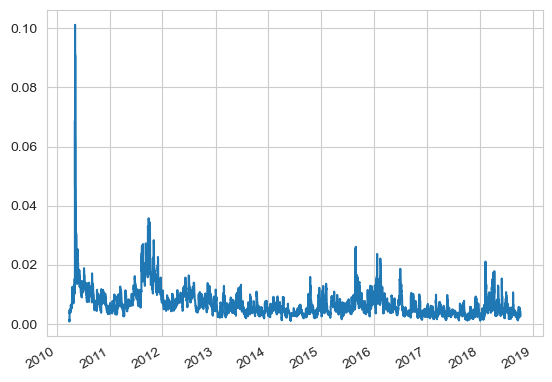

In [14]:
dailyVol.plot()

Vertical Barrier

In [15]:
t1 = fml.addVerticalBarrier(tEvents, feature_Mat.dollar, numDays = 10)
t1

2010-03-26 12:19:32   2010-04-05 13:01:16
2010-03-26 13:17:41   2010-04-05 13:47:13
2010-03-26 14:06:01   2010-04-05 14:24:58
2010-03-26 14:53:39   2010-04-05 15:17:22
2010-03-26 15:29:01   2010-04-05 15:33:26
                              ...        
2018-09-25 14:53:26   2018-10-05 14:56:39
2018-09-25 15:06:29   2018-10-05 15:08:37
2018-09-25 15:26:08   2018-10-05 15:27:58
2018-09-25 15:38:09   2018-10-05 15:45:00
2018-09-25 15:41:43   2018-10-05 15:45:00
Length: 37893, dtype: datetime64[ns]

In [16]:
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
ptsl = [1,1]
target = dailyVol * 2
minRet = 0.001
cpus = cpu_count() - 1
events = fml.getEvents(feature_Mat.dollar, tEvents, ptsl, target, minRet, cpus, t1 = t1)

2023-06-14 19:18:19.949803 100.0% getTripleBarrier done after 0.21 minutes. Remaining 0.0 minutes..


In [17]:
events

,t1,trgt
2010-03-29 11:35:33,2010-03-30 11:41:46,0.003047
2010-03-29 12:43:27,2010-03-30 09:54:51,0.003092
2010-03-29 13:37:29,2010-03-30 09:54:51,0.002507
2010-03-29 13:54:30,2010-03-30 09:54:51,0.002179
2010-03-29 14:23:55,2010-03-30 09:54:51,0.001929
...,...,...
2018-10-05 15:22:55,NaT,0.005836
2018-10-05 15:27:58,NaT,0.005743
2018-10-05 15:33:58,NaT,0.005633
2018-10-05 15:45:00,NaT,0.005525


Concurrent Events

In [18]:
numCoEvents = fml.mpPandasObj(fml.getConcurrentBar, ('molecule', events.index), cpus, closeIdx = feature_Mat.index, t1 = events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep = 'last')]
numCoEvents = numCoEvents.reindex(feature_Mat.index).fillna(0)
out = pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.getAvgLabelUniq, ('molecule', events.index), cpus, t1 = events['t1'], numCoEvents = numCoEvents)
out

2023-06-14 19:18:29.479531 100.0% getConcurrentBar done after 0.14 minutes. Remaining 0.0 minutes..
2023-06-14 19:18:37.759721 100.0% getAvgLabelUniq done after 0.12 minutes. Remaining 0.0 minutes..


,tW
2010-03-29 11:35:33,0.352910
2010-03-29 12:43:27,0.265476
2010-03-29 13:37:29,0.218571
2010-03-29 13:54:30,0.189881
2010-03-29 14:23:55,0.169841
...,...
2018-10-05 15:22:55,0.009092
2018-10-05 15:27:58,0.009051
2018-10-05 15:33:58,0.009009
2018-10-05 15:45:00,0.008969


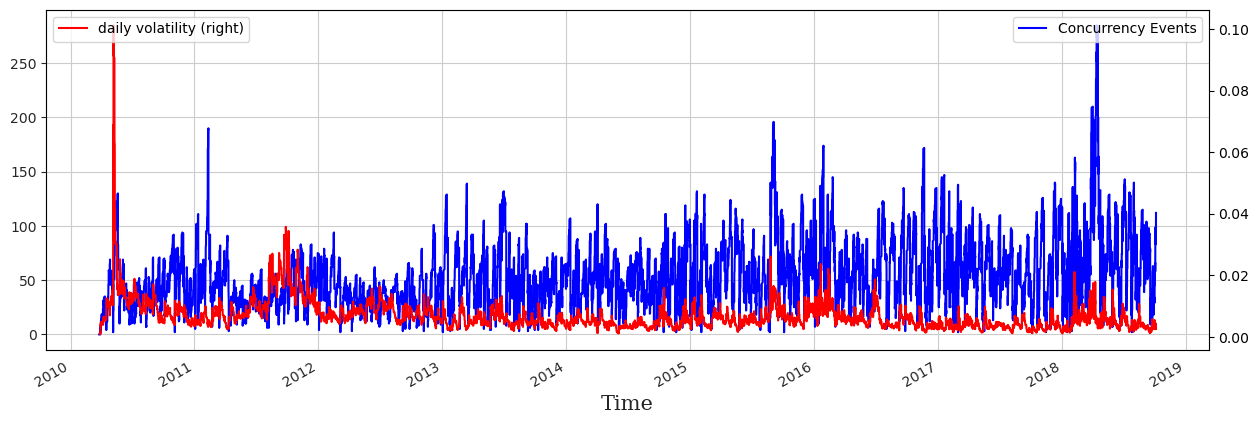

In [19]:
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

plt.style.use('default')
ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

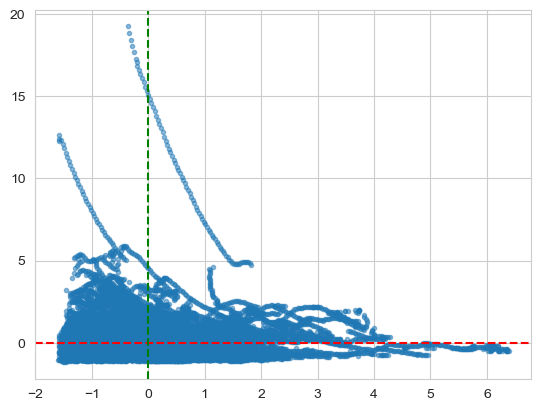

In [20]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

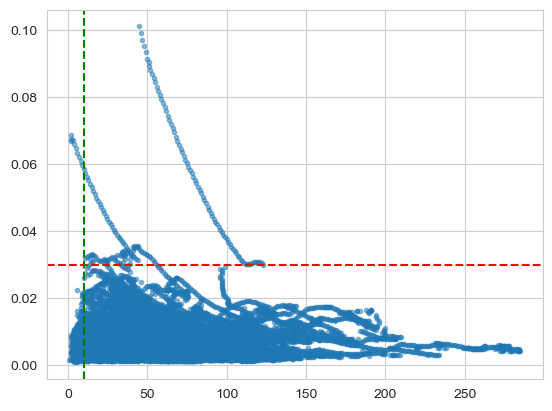

In [21]:
plt.scatter(combine['coEvents'], combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

Weights

In [22]:
out['w'] = fml.mpPandasObj(fml.mpSampleW, ('molecule', events.index),
                           cpus, t1 = events['t1'], numCoEvents = numCoEvents, close = feature_Mat.dollar)
out['w'] *= out.shape[0] / out['w'].sum()
out

2023-06-14 19:18:49.293525 100.0% mpSampleW done after 0.14 minutes. Remaining 0.0 minutes..


,tW,w
2010-03-29 11:35:33,0.352910,0.245857
2010-03-29 12:43:27,0.265476,1.825446
2010-03-29 13:37:29,0.218571,3.834388
2010-03-29 13:54:30,0.189881,2.483918
2010-03-29 14:23:55,0.169841,1.977894
...,...,...
2018-10-05 15:22:55,0.009092,0.013812
2018-10-05 15:27:58,0.009051,0.025995
2018-10-05 15:33:58,0.009009,0.038071
2018-10-05 15:45:00,0.008969,0.056029


1.0 0.0
-0.8751 0.0024
-2.1536 0.004
-4.3036 0.0067
-5.5808 0.0083
-7.9196 0.0113


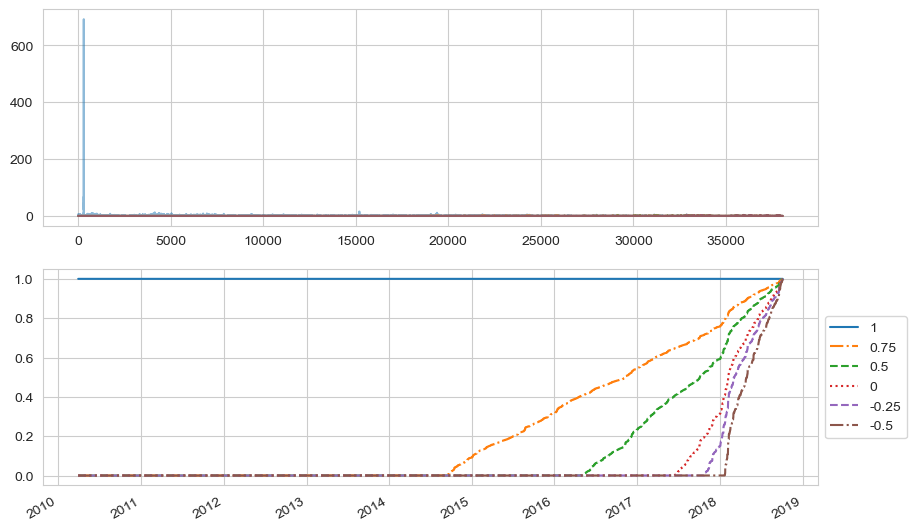

In [23]:
def getExTimeDecay(tW, clfLastW = 1.,exponent = 1):
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0: slope = ((1.-clfLastW)/clfW.iloc[-1]) ** exponent
    else: slope = (1./((clfLastW + 1) * clfW.iloc[-1])) ** exponent
    const = 1.-slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(round(const, 4), round(slope, 4))
    return clfW

f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(),
                                 clfLastW = lstW,
                                 exponent = 0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index = out['w'].dropna().index) * decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [24]:
s

2010-03-29 11:35:33    0.000000
2010-03-29 12:43:27    0.000000
2010-03-29 13:37:29    0.000000
2010-03-29 13:54:30    0.000000
2010-03-29 14:23:55    0.000000
                         ...   
2018-10-05 15:22:55    0.999595
2018-10-05 15:27:58    0.999697
2018-10-05 15:33:58    0.999798
2018-10-05 15:45:00    0.999899
2018-10-05 15:48:02    1.000000
Length: 38080, dtype: float64

In [25]:
feature_Mat = feature_Mat.join(out, how = 'left').join(target, how = 'left').dropna()
feature_Mat

,dollar,frac_diff_dollar,tW,w,dailyVol
2010-03-29 11:35:33,56.7478,2.415922,0.352910,0.245857,0.003047
2010-03-29 12:43:27,56.5800,2.195724,0.265476,1.825446,0.003092
2010-03-29 13:37:29,56.6400,2.304713,0.218571,3.834388,0.002507
2010-03-29 13:54:30,56.6700,2.320277,0.189881,2.483918,0.002179
2010-03-29 14:23:55,56.6500,2.284524,0.169841,1.977894,0.001929
...,...,...,...,...,...
2018-10-05 15:22:55,116.1800,4.203804,0.009092,0.013812,0.005836
2018-10-05 15:27:58,116.1400,4.162418,0.009051,0.025995,0.005743
2018-10-05 15:33:58,116.0800,4.114779,0.009009,0.038071,0.005633
2018-10-05 15:45:00,116.1597,4.220865,0.008969,0.056029,0.005525


RSI

In [26]:
# Compute RSI
def calculate_rsi(prices, window):
    deltas = prices.diff()
    up = deltas.clip(lower=0)
    down = deltas.clip(upper=0).abs()

    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = calculate_rsi(df['dollar'], window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [27]:
data = feature_Mat.copy()
rsi_windows = [5, 13, 35]
for w in rsi_windows:
    rsi = get_rsi(data, window = w).squeeze()
    data[f'rsi_{w}'] = rsi

In [28]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35
2010-03-29 11:35:33,56.7478,2.415922,0.352910,0.245857,0.003047,NaN,NaN,NaN
2010-03-29 12:43:27,56.5800,2.195724,0.265476,1.825446,0.003092,NaN,NaN,NaN
2010-03-29 13:37:29,56.6400,2.304713,0.218571,3.834388,0.002507,NaN,NaN,NaN
2010-03-29 13:54:30,56.6700,2.320277,0.189881,2.483918,0.002179,NaN,NaN,NaN
2010-03-29 14:23:55,56.6500,2.284524,0.169841,1.977894,0.001929,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2018-10-05 15:22:55,116.1800,4.203804,0.009092,0.013812,0.005836,63.246554,52.780352,51.958442
2018-10-05 15:27:58,116.1400,4.162418,0.009051,0.025995,0.005743,51.515152,59.144252,49.715812
2018-10-05 15:33:58,116.0800,4.114779,0.009009,0.038071,0.005633,54.838710,61.072386,50.670529
2018-10-05 15:45:00,116.1597,4.220865,0.008969,0.056029,0.005525,64.074929,66.639294,52.133390


autocorr

In [29]:
data['log_ret'] = np.log(data['dollar']).diff()

window_autocorr = 50
data['autocorr_1'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

data['autocorr_3'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

data['autocorr_5'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

In [30]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35,log_ret,autocorr_1,autocorr_3,autocorr_5
2010-03-29 11:35:33,56.7478,2.415922,0.352910,0.245857,0.003047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-29 12:43:27,56.5800,2.195724,0.265476,1.825446,0.003092,NaN,NaN,NaN,-0.002961,NaN,NaN,NaN
2010-03-29 13:37:29,56.6400,2.304713,0.218571,3.834388,0.002507,NaN,NaN,NaN,0.001060,NaN,NaN,NaN
2010-03-29 13:54:30,56.6700,2.320277,0.189881,2.483918,0.002179,NaN,NaN,NaN,0.000530,NaN,NaN,NaN
2010-03-29 14:23:55,56.6500,2.284524,0.169841,1.977894,0.001929,NaN,NaN,NaN,-0.000353,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-05 15:22:55,116.1800,4.203804,0.009092,0.013812,0.005836,63.246554,52.780352,51.958442,-0.000344,0.207253,-0.227888,0.173988
2018-10-05 15:27:58,116.1400,4.162418,0.009051,0.025995,0.005743,51.515152,59.144252,49.715812,-0.000344,0.215394,-0.238790,0.171329
2018-10-05 15:33:58,116.0800,4.114779,0.009009,0.038071,0.005633,54.838710,61.072386,50.670529,-0.000517,0.218059,-0.248634,0.183697
2018-10-05 15:45:00,116.1597,4.220865,0.008969,0.056029,0.005525,64.074929,66.639294,52.133390,0.000686,0.208097,-0.252287,0.183455


labeling

In [31]:
labels = fml.getBins(events, feature_Mat.dollar)
clean_labels = fml.dropLabels(labels, 0.05)
clean_labels

dropped label 0.0 0.00018436578171091445


,ret,bin
2010-03-29 11:35:33,-0.003662,-1.0
2010-03-29 12:43:27,0.005302,1.0
2010-03-29 13:37:29,0.004237,1.0
2010-03-29 13:54:30,0.003706,1.0
2010-03-29 14:23:55,0.004060,1.0
...,...,...
2018-10-04 09:53:51,-0.005452,-1.0
2018-10-04 09:58:21,-0.005402,-1.0
2018-10-04 10:02:47,-0.005573,-1.0
2018-10-04 10:11:07,-0.005804,-1.0


feature matrix

In [ ]:
from multiprocessing import Pool
import test

if __name__ == "__main__":
    with Pool() as pool:
        seqUs = test.main_mp(t1)
        #result = pool.map(test.main_mp(t1), range(10))
        #print(result)

023-06-14 19:32:22.210069 15.0% mp_func done after 13.16 minutes. Remaining 74.58 minutes.2023-06-14 19:38:40.193915 17.0% mp_func done after 19.46 minutes. Remaining 95.02 minutes.2023-06-14 19:38:44.987503 19.0% mp_func done after 19.54 minutes. Remaining 83.31 minutes.2023-06-14 19:38:55.218697 21.0% mp_func done after 19.71 minutes. Remaining 74.15 minutes.2023-06-14 19:39:01.663955 23.0% mp_func done after 19.82 minutes. Remaining 66.35 minutes.2023-06-14 19:45:41.822726 25.0% mp_func done after 26.49 minutes. Remaining 79.47 minutes.2023-06-14 19:45:42.686661 27.0% mp_func done after 26.5 minutes. Remaining 71.66 minutes.2023-06-14 19:46:00.439060 29.0% mp_func done after 26.8 minutes. Remaining 65.61 minutes.2023-06-14 19:46:06.776819 31.0% mp_func done after 26.9 minutes. Remaining 59.88 minutes.2023-06-14 19:52:36.884169 33.0% mp_func done after 33.41 minutes. Remaining 67.83 minutes.2023-06-14 19:52:39.617190 35.0% mp_func done after 33.45 minutes. Remaining 62.13 minutes.202

In [ ]:
avg_uniqueness = seqUs.mean()[0]
avgU1 = out['tW'].mean()

#### Primary Model

In [ ]:
target = clean_labels.bin
target

In [ ]:
data = data.join(target, how = 'left').dropna()
data

### Secondary Model
use Primary Model Prediction

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

#### RandomForest Classifier

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from scipy import interp

rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state = 42, class_weight = 'balanced_subsample', oob_score = False)

cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(rf, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', bootstrap = True,
                                    class_weight = 'balanced_subsample', random_state = 42, oob_score = False)
fml.crossValPlot(skf, classifier, X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

fit = rf.fit(X_train, y_train)

y_pred_rf = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'RandomForest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Feature Importance

In [ ]:
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.axvline(1. / feat_imp.shape[0], linewidth = 1, color='r', linestyle='dotted')
plt.xlabel('Feature Importance Score')
plt.show()

#### DecisionTree & Bagging Classifier

In [ ]:
n_estimator = 1000
dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
bc = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                       max_samples = avgU1, max_features = 1., random_state = 42)

In [ ]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

In [ ]:
y_pred_bc = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### RandomForest & Bagging Classifier

In [ ]:
n_estimator = 1000
rf2 = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample')
bc2 = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                        max_samples = avgU1, max_features = 1., random_state = 42)

fit = bc2.fit(X_train, y_train)

In [ ]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc2, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

In [ ]:
y_pred_bc2 = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
yprf = pd.Series(y_pred_rf, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)

In [ ]:
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = ((yt[0] - yt[0].min()) / (yt[0].max() - yt[0].min()) - 0.5) * 2
yt = pd.concat([yt, z], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size']
yt

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['pred_prob'][yt['bin'] == 1.0], yt['log_ret'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['pred_prob'][yt['bin'] == 1.0]), np.max(yt['pred_prob'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data = yt, x = 'pred_prob', y="log_ret", hue='bin', palette='flare', ax=ax)
plt.show()

yt['log_ret'][yt['bin'] == 1][yt['pred_prob'] >= 0.5].cumsum().plot(label = 'Machine Learning Model', figsize = (10,5))
yt['log_ret'].cumsum().plot(label = 'KOSPI200 future')
plt.legend()

In [ ]:
yprf = pd.Series(y_pred_bc, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = ((yt[0] - yt[0].min()) / (yt[0].max() - yt[0].min()) - 0.5) * 2
yt = pd.concat([yt, z], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size']
fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['pred_prob'][yt['bin'] == 1.0], yt['log_ret'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['pred_prob'][yt['bin'] == 1.0]), np.max(yt['pred_prob'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data = yt, x = 'pred_prob', y="log_ret", hue='bin', palette='flare', ax=ax)
plt.show()

yt['log_ret'][yt['bin'] == 1][yt['pred_prob'] >= 0.5].cumsum().plot(label = 'Machine Learning Model', figsize = (10,5))
yt['log_ret'].cumsum().plot(label = 'KOSPI200 future')
plt.legend()
plt.show()

In [ ]:
yprf = pd.Series(y_pred_bc2, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = ((yt[0] - yt[0].min()) / (yt[0].max() - yt[0].min()) - 0.5) * 2
yt = pd.concat([yt, z], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size']
fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['pred_prob'][yt['bin'] == 1.0], yt['log_ret'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['pred_prob'][yt['bin'] == 1.0]), np.max(yt['pred_prob'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data = yt, x = 'pred_prob', y="log_ret", hue='bin', palette='flare', ax=ax)
plt.show()

yt['log_ret'][yt['bin'] == 1][yt['pred_prob'] >= 0.5].cumsum().plot(label = 'Machine Learning Model', figsize = (10,5))
yt['log_ret'].cumsum().plot(label = 'KOSPI200 future')
plt.legend()
plt.show()